In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

from num_methods.integral import TrapzIntegral
from numpy import sqrt, sin, cos, pi

def mk_plot(func, rng, label, same=False):
    plt.plot(rng, [func(x) for x in rng], label=label)
    plt.grid(True)
    plt.legend()
    if not same:
        plt.show()

## Подготовка

Будем использовать для тестов следующие функции

Обычная:

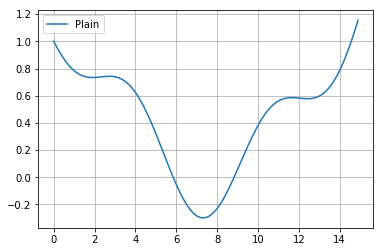

In [2]:
plain_func = lambda x: special.jv(2.5, x) + (x ** 2 - 14 * x + 49) / 49

mk_plot(plain_func, main_rng, 'Plain')

С разрывом:

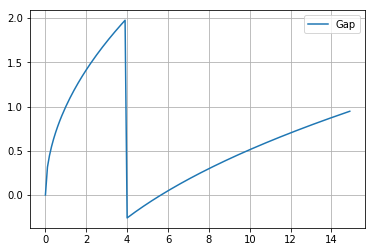

In [3]:
gap_func = lambda x: x ** 0.5 if x < 4. else x ** 0.4 - 2.

mk_plot(gap_func, main_rng, 'Gap')

Осцелирующая:

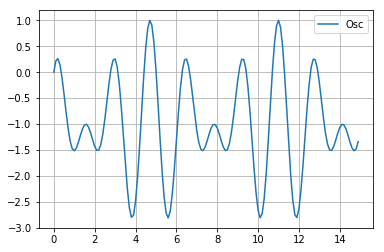

In [4]:
osc_func = lambda x: sin(x * 3) + cos(x * 4) - 1

mk_plot(osc_func, main_rng, 'Osc')

## Численное интегрирование

###  Метод трапеций

Реализуем метод трапеций (пока что лишь для равномерных сеток).

Простая формула для метода трапеций на отрезке $[a, b]$: $(b - a) \cdot \frac{f(a) + f(b)}{2}$

Составная формула
$$\frac{f(a)}{2} (x_1 - a) + \sum_{i=1}^{n-1} \frac{f(x_i)}{2} (x_{i+1} - x_{i-1}) + \frac{f(b)}{2} (b - x_{n-1})$$
для равномерной сетки шага $h$
$$I_{trap} \approx h\left( \frac{f(a) + f(b)}{2} + \sum_{i=1}^{n - 1} f(a + hi) \right)$$

Погрешность можно оценить как $|I_* - I_{trap}| \le ch^2$, где $I_*$ -- реальное значение интеграла.

Вычеслим интегралы на отрезке $[0, 15]$ с числом узлов 10000 и сравним с библиотечным методом.

In [ ]:
beg = 0
end = 15
main_rng = np.arange(beg, end, 0.1)

In [5]:
funcs = [(gap_func, 'Gap'), (osc_func, 'Osc'), (plain_func, 'Plain')]

for func, name in funcs:
    res = integrate.quad(func, beg, end)[0]
    print(f'Framework method result is {res:.4f}')
    my_res = TrapzIntegral(func, nodes_num=10000)(beg, end)
    print('Trapeze integral of', name, f'function is {my_res:.4f}')
    print()

Framework method result is 10.0107
Trapeze integral of Gap function is 10.0110

Framework method result is -14.9180
Trapeze integral of Osc function is -14.9180

Framework method result is 6.6371
Trapeze integral of Plain function is 6.6371



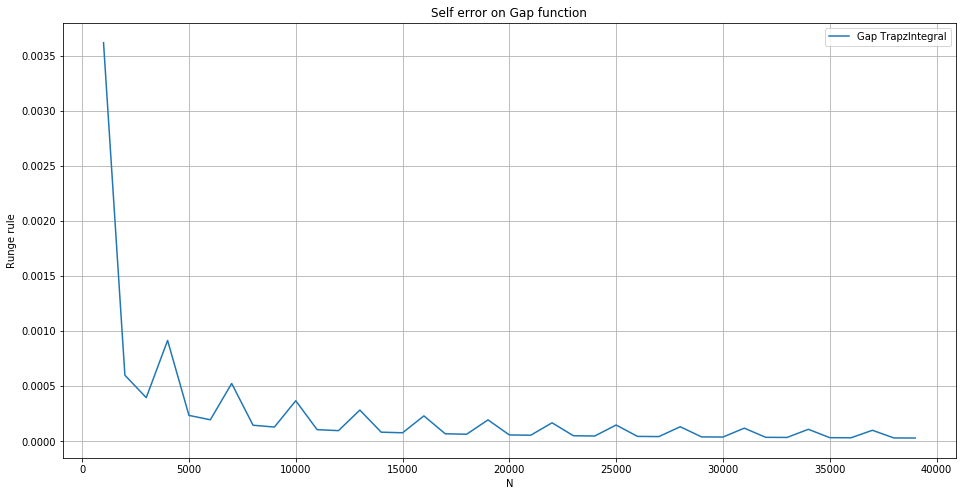

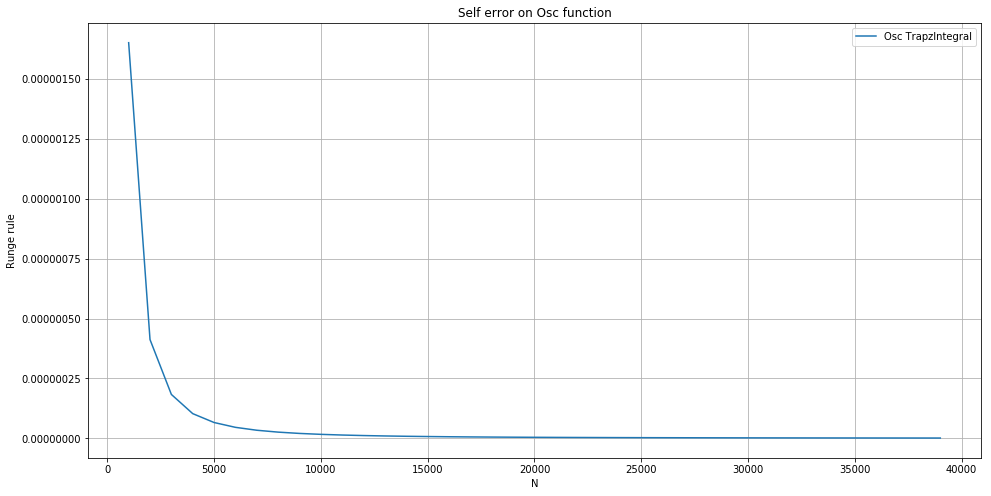

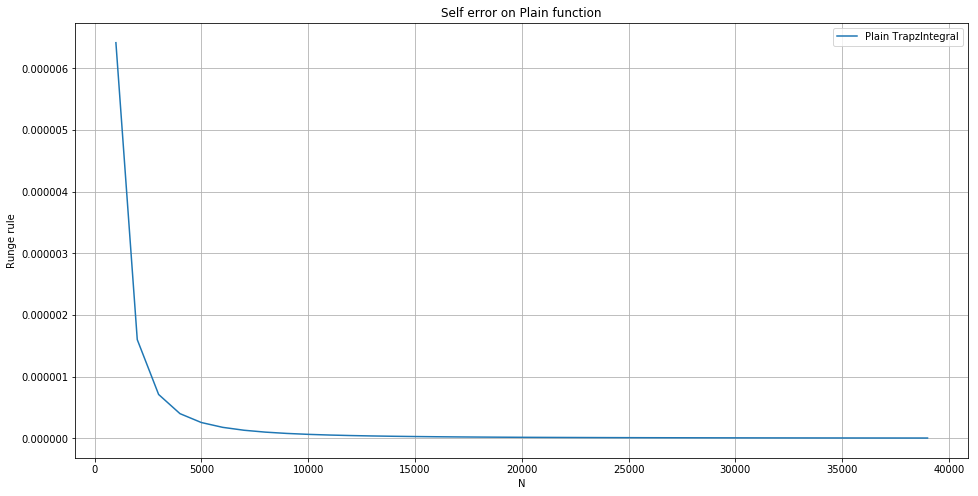

In [6]:
from functools import partial

def self_error(nodes_num, method, func=None):
    return method.error(func, beg, end, nodes_num)

def error_compare(nodes_num, method, func=None):
    etalon, err = integrate.quad(func, beg, end)
    integr = method(func, nodes_num=nodes_num)
    my_val = integr(begin=beg, end=end)

    return abs(my_val - etalon)

for func, name in [(gap_func, 'Gap'), (osc_func, 'Osc'), (plain_func, 'Plain')]:
    plt.figure(figsize=(16, 8))
    rng = np.arange(1000, 40000, 1000)
    for method in [TrapzIntegral]:
        plt.title(f'Self error on {name} function')
        mk_plot(
            partial(self_error, func=func, method=method),
            rng,
            name + ' ' + method.__name__,
            same=True
        )

        plt.xlabel('N')
        plt.ylabel('Runge rule')
        plt.show()

Видно, что для разрывной функции ошибка сильно скачет.

Построим график относительной ошибки в лог-scale для осцелирующей функции.

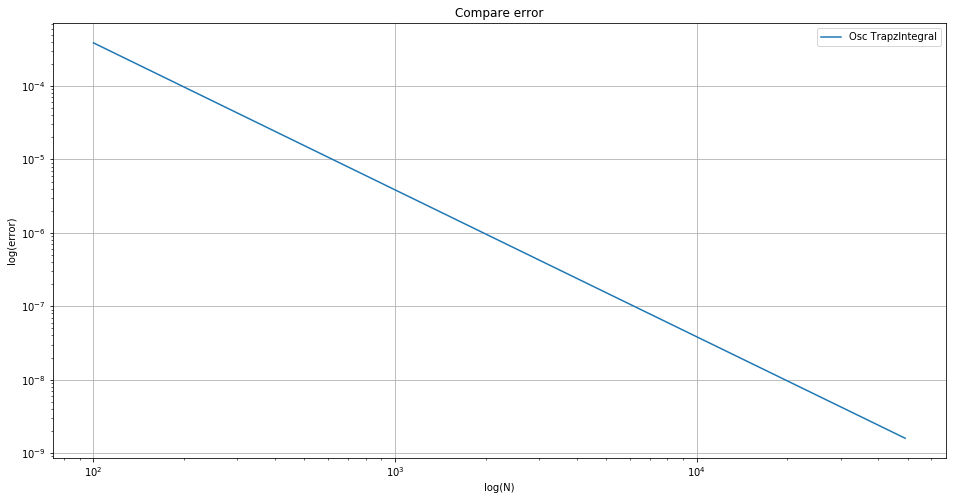

In [7]:
for func, name in [(osc_func, 'Osc')]:
    rng = np.arange(100, 50000, 1000)
    plt.figure(figsize=(16, 8))
    for method in [TrapzIntegral]:
        mk_plot(
            partial(error_compare, func=func, method=method),
            rng,
            name + ' ' + method.__name__,
            same=True
        )

plt.title('Compare error')
plt.xlabel('log(N)')
plt.ylabel('log(error)')
plt.yscale('log')
plt.xscale('log')
plt.show()

Видно, что коэфициент наклона $\approx -2$, а смещение можно оценить на глазок как $0.5$. Тогда можно оценить $c$ как 
$e^{\sqrt{10}}$, а порядок точности – 3-кой, что подтверждает аналитическую оценку.

Выводы: работает вполне точно для неразрывных функций.

## Итерполяция
### Кубический сплайн деффекта 1

#### Демонстрация

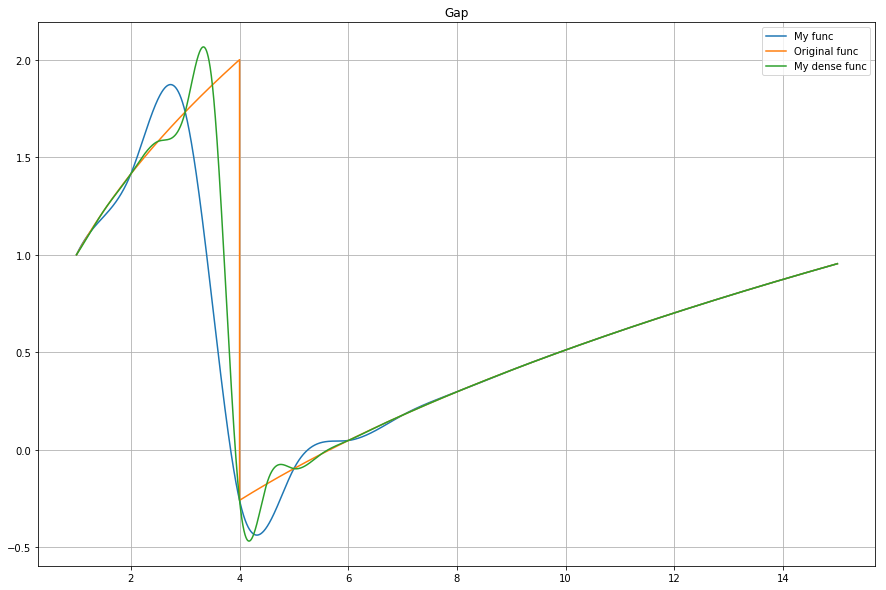

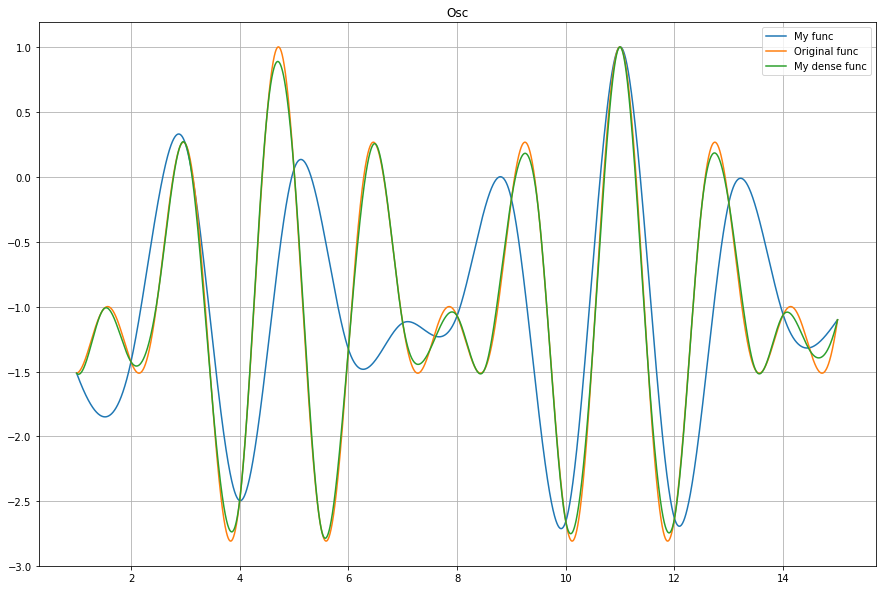

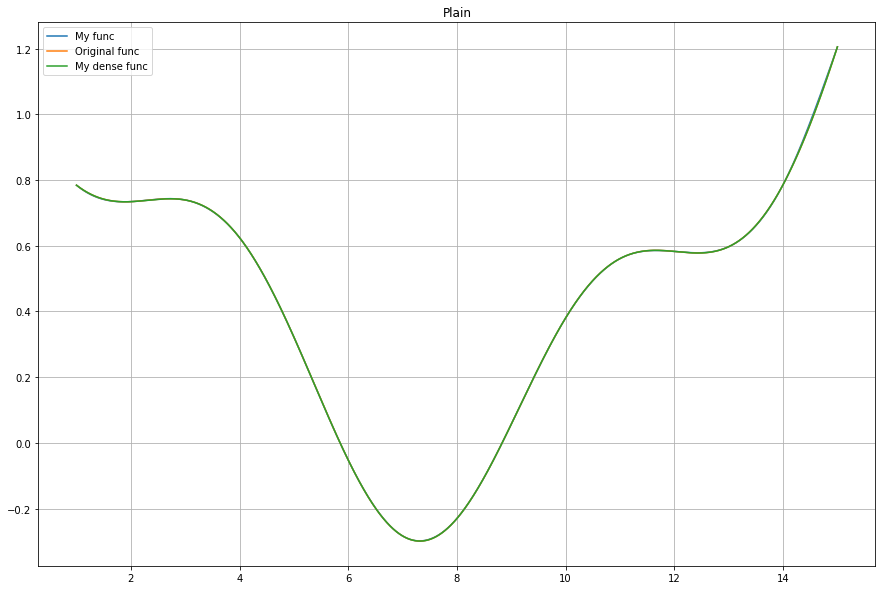

In [12]:
from utils import Tabulate
from num_methods.interpolation import SplineInterpolation

grid_conf = (0, 16, 1.0)
dense_grid_conf = (0, 16, 0.5)

test_x = np.arange(1, 15, 0.0003)

for func, name in funcs:
    grid = Tabulate(func, grid_conf)
    dense_grid = Tabulate(func, dense_grid_conf)

    my_func = SplineInterpolation(grid)
    my_dense_func = SplineInterpolation(dense_grid)

    plt.figure(figsize=(15, 10))
    plt.title(f'{name}')
    mk_plot(my_func, test_x, label=f'My func', same=True)
    mk_plot(func, test_x, label=f'Original func', same=True)
    mk_plot(my_dense_func, test_x, label=f'My dense func')


#### Графики ошибок:

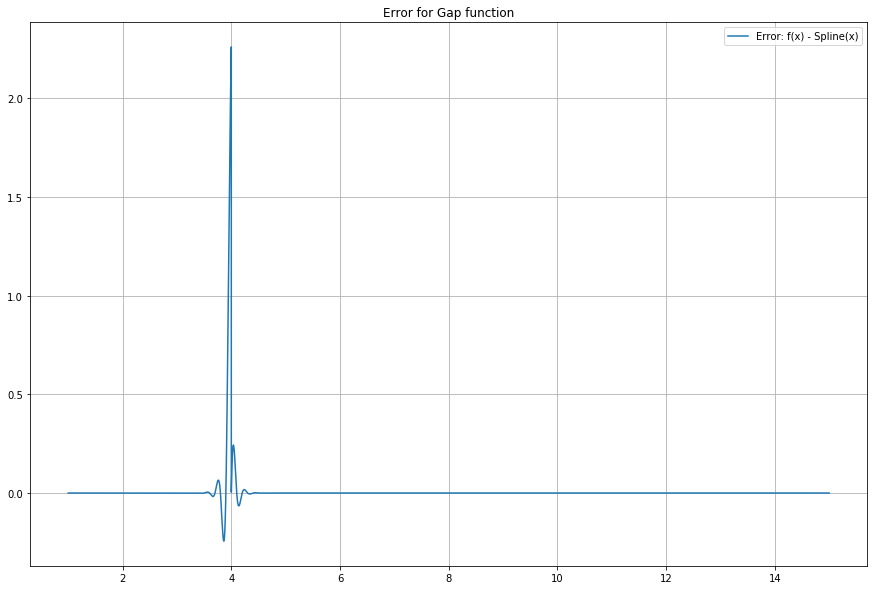

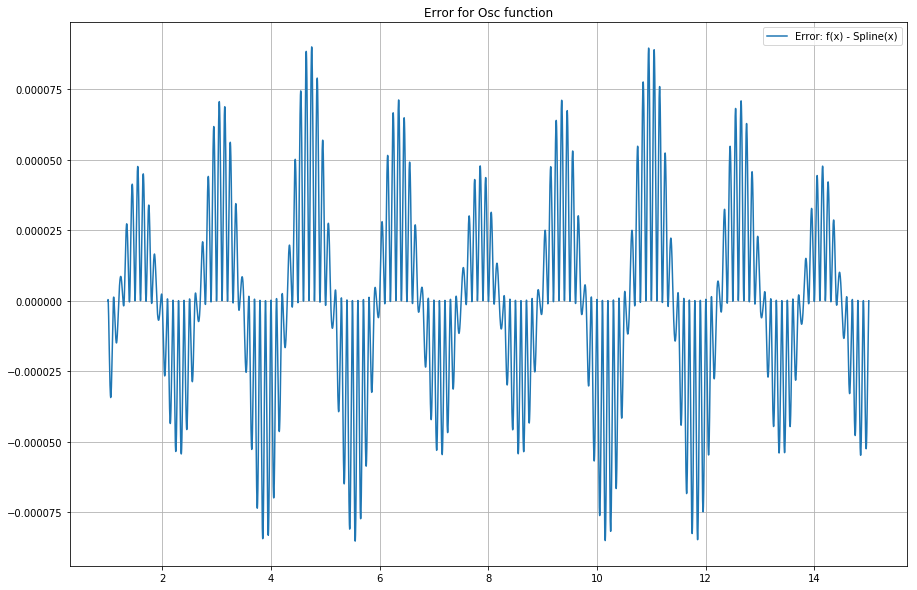

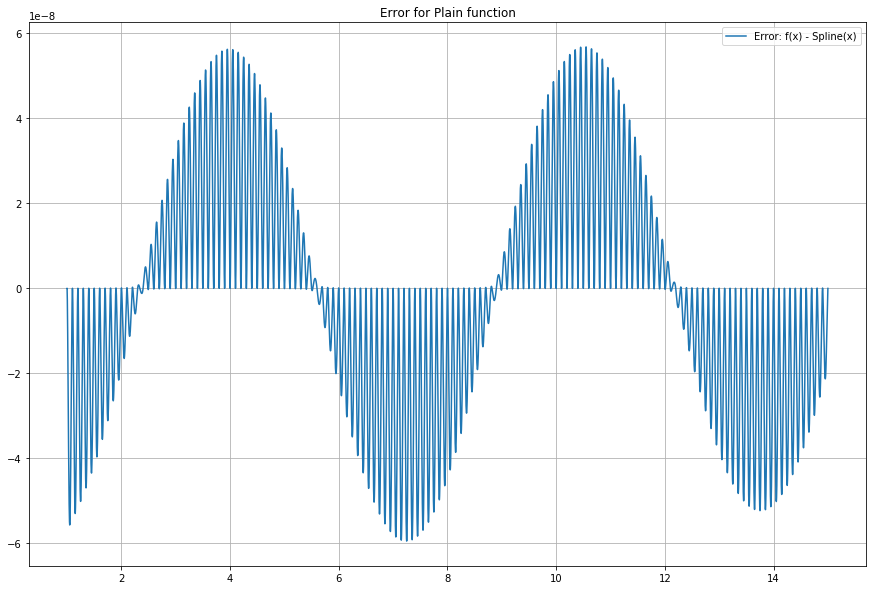

In [11]:
for func, name in funcs:
    dense_grid = Tabulate(func, dense_grid_conf)
    my_dense_func = SplineInterpolation(dense_grid)

    plt.figure(figsize=(15, 10))
    plt.title(f'Error for {name} function')
    mk_plot(lambda x: func(x) - my_dense_func(x), test_x, label=f'Error: f(x) - Spline(x)')

##### Описание метода:

Пусть дана сетка $\{(t_0, f_0), ..., (t_{N - 1}, f_{N - 1}), (t_{N}, f_{N})\}$.

Пусть $\tau_n = t_{n + 1} - t_{n}$, $n=1..N-1$.

Тогда на $[t_n, t_{n + 1}]$ представляем $S(t)$:

$$
\frac{1}{6\tau_n}
\left(
m_n(t_{n + 1} - t)^3 + m_{n + 1}(t - t_n)^3)
+
\alpha_n(t_{n + 1} - t) + \beta_n(t - t_{n})
\right)
$$

Где $\alpha_n = \frac{f_n}{\tau_n} - \frac{m_n\tau_n}{6}$,
    $\beta = \frac{f_{n + 1}}{\tau_n} - \frac{m_{n + 1}\tau_n}{6}$,
а $m_n$ – значение второй производной $f$ в точке $t_n$. Будем интерполировать свободным сплайном ($m_0=m_N=0$).

Находим $m_n$ решая систему:
$$
 \begin{cases}
   \frac{\tau_0 + \tau_1}{3}m_1 + \frac{\tau_1}{6}m_2& = \frac{f_2 - f_1}{\tau_1} - \frac{f_1 - f_0}{\tau_0}\\
   \vdots \\
   \frac{\tau_{n - 1}}{6}m_{n - 1} + \frac{\tau_{n - 1} + \tau{n}}{3}m_{n} + \frac{\tau_{n}}{6}m_{n + 1}& 
   = \frac{f_{n + 1} - f_{n}}{\tau_{n}} - \frac{f_{n} - f_{n - 1}}{\tau_{n - 1}}\\
   \vdots \\
   \frac{\tau_{N - 2}}{6}m_{N - 2} + \frac{\tau_{N - 2} + \tau{N - 1}}{3}m_{N - 1}& = \frac{f_N - f_{N - 1}}{\tau_{N - 1}} - \frac{f_{N - 1} - f_{N - 2}}{\tau_{N - 2}}
 \end{cases}
$$

Решаем методом прогонки:

\begin{pmatrix}
b_0 & c_0 \\
a_1 & b_1 & c_1 \\
& a_3 & \ddots & \ddots \\
& & \ddots & \ddots & c_{N - 3} \\
& & & a_{N-2} & b_{N - 2}
\end{pmatrix}

$$\times$$

\begin{pmatrix}
m_1 \\
m_2 \\
\vdots \\
m_{N - 2}\\
m_{N - 1}
\end{pmatrix}

$$ = $$

\begin{pmatrix}
d_0 \\
d_1 \\
\vdots \\
d_{N - 3}\\
d_{N - 2}
\end{pmatrix}

Прямой проход:

$$
\begin{array}{lcl}
w_i=\cfrac{a_i}{b_{i-1}}\\
b_i:=b_i-w_i c_{i-1}\\
d_i:=d_i-w_i d_{i-1}
\end{array} ,   i=1,2, \dots, N - 2
$$

Затем обратным проходом находим решение:

$$
\begin{array}{lcl}
m_{N - 1}=\cfrac{d_{N - 2}}{b_{N - 2}}\\
m_{i + 1} =\cfrac{d_i-c_i m_{i+2}}{b_i} ,   i=N-3, \dots, 0
\end{array}
$$

## Решение СДУ
### Схемы Рунге-Кутты 4-ого порядка

Будем тестировать на следующей системе:

$$
 \begin{cases}
   x^\prime = 2x - 5y + 3\\
   y^\prime = 5x - 6y + 1\\
   x(0) = 6\\
   y(0) = 5
 \end{cases}
$$

С известным аналитическим решением:

$$
 \begin{cases}
   x(t) = 5e^{-5t}\cos 3t + 1\\
   y(t) = e^{-2t}(4 \cos 3t + 3 \sin 3t) + 1\\
 \end{cases}
$$


In [17]:
from num_methods.solver import CauchySolver
from scipy.integrate import ode

f1 = lambda t, x, y: 2. * x - 5 * y + 3.
f2 = lambda t, x, y: 5. * x - 6. * y + 1
x0 = 6
y0 = 5

anal_solution = [
    lambda t: 5. * np.exp(-2. * t) * np.cos(3. * t) + 1.,
    lambda t: np.exp(-2. * t) * (4. * np.cos(3. * t) + 3. * np.sin(3. * t)) + 1.
]

solver = CauchySolver([f1, f2])
grid, solution = solver.solve([x0, y0], T=10, h=0.001)

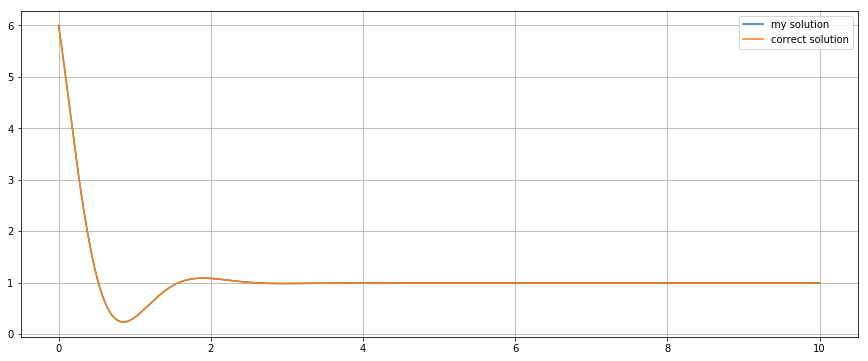

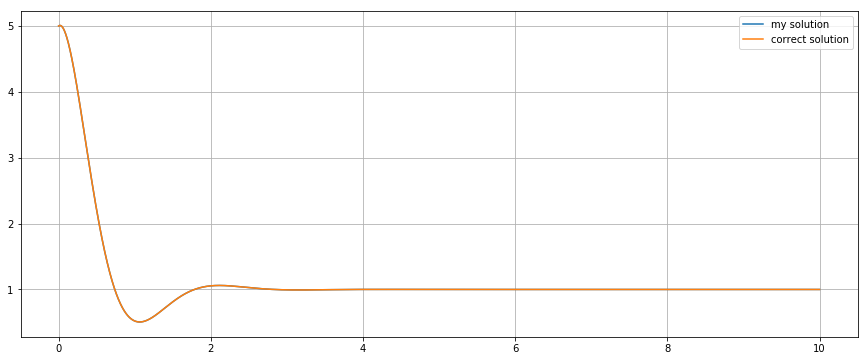

In [18]:
for correct_func, my_points in zip(anal_solution, solution):
    plt.figure(figsize=(15, 6))
    plt.plot(grid, my_points, label='my solution')
    plt.plot(grid, [correct_func(t) for t in grid], label='correct solution')
    plt.grid(True)
    plt.legend()
    plt.show()

In [44]:
errors = np.zeros((2, 1000))
h_array = np.logspace(-1, -3, num=1000, base=10)
for i, h in enumerate(h_array):
    grid, solution = solver.solve([x0, y0], T=10, h=h)
    err_per_h = []
    for correct_func, my_points in zip(anal_solution, solution):
        err = np.max(np.abs(np.array([correct_func(t) for t in grid]) - my_points))
        err_per_h.append(err)
    errors[0, i] = err_per_h[0]
    errors[1, i] = err_per_h[1]

In [45]:
def error(err_val, title=''):
    plt.figure(figsize=(15, 8))
    plt.plot(h_array, err_val.flatten())
    plt.title(title)
    plt.xlabel('log(h)')
    plt.ylabel('log(error)')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

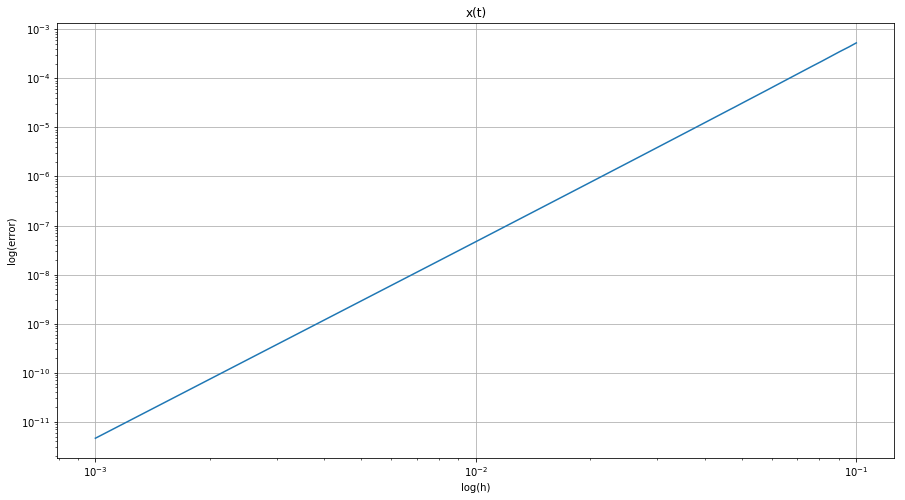

In [48]:
error(errors[0, :], 'x(t)')

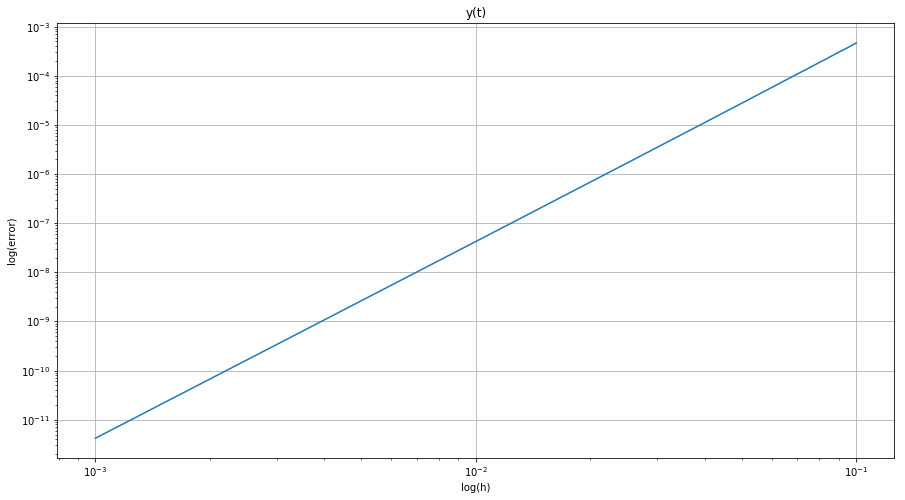

In [49]:
error(errors[1, :], 'y(t)')

Судя по наклону метод имеет 4-ый порядок точности.

In [58]:
x = np.arange(0, 5, 1)
y = np.arange(0, 5, 1)
xx, yy = np.meshgrid(x, y)
xx

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])